In [1]:
import os
import datetime
from tqdm import tqdm

import numpy as np

import cv2
%matplotlib inline
from matplotlib import pyplot as plt
import skimage
from skimage import exposure, io

import torch
import torch.nn as nn
import torch.optim as optim

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

torch.backends.cudnn.benchmark = True

import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp

#torch.manual_seed(123)
torch.manual_seed(1)

dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#dev = 'cpu'

In [2]:
# dir
listdir='../list/'
imagedir='../images/'
paramsdir='../params/'
listfile='list_dataset.txt'
#listfile='list_dataset2.txt'
paramsfile="params.pth"

# image size
figsize = 512

# epochs
epoch_init = 0
#epoch_max = 2000
epoch_max = 10


# batchsize
batch_size = 64

#encoder
encoder='resnet18'
encoder_weights=None

activation='sigmoid'

resize_inter=cv2.INTER_AREA



## Function

In [3]:
def preprocess(img,mn=0.1,mx=99.9):
    mx1 = np.max(img).astype(np.float32)
    mn1 = np.min(img).astype(np.float32)
    img = (img.astype(np.float32)-mn1)/(mx1-mn1)
    img = np.where(img >= 1.0, 1.0, img)
    img = np.where(img <= 0.0, 0.0, img)

    i, j = np.percentile(img, (mn,mx))
    img = exposure.rescale_intensity(img, in_range=(i,j)).astype(np.float32)
    
    return img

def MySSIM(im1,im2,window_size=11):
    C1=0.01**2
    C2=0.03**2
    
    mu1 = nn.functional.avg_pool2d(input=im1, kernel_size=window_size, stride=1, padding=0)
    mu2 = nn.functional.avg_pool2d(input=im2, kernel_size=window_size, stride=1, padding=0)
    
    im1=im1[:,:,(window_size-1)//2:-(window_size-1)//2,(window_size-1)//2:-(window_size-1)//2]
    im2=im2[:,:,(window_size-1)//2:-(window_size-1)//2,(window_size-1)//2:-(window_size-1)//2]

    s1=nn.functional.avg_pool2d((im1-mu1)**2, kernel_size=window_size, stride=1, padding=0)
    s2=nn.functional.avg_pool2d((im2-mu2)**2, kernel_size=window_size, stride=1, padding=0)
    
    s12=nn.functional.avg_pool2d((im1-mu1)*(im2-mu2), kernel_size=window_size, stride=1, padding=0)

    mu1=mu1[:,:,(window_size-1)//2:-(window_size-1)//2,(window_size-1)//2:-(window_size-1)//2]
    mu2=mu2[:,:,(window_size-1)//2:-(window_size-1)//2,(window_size-1)//2:-(window_size-1)//2]
    
    total=((2*mu1*mu2 + C1) * (2*s12 + C2) / ((mu1**2 + mu2**2 + C1) * (s1 + s2 + C2))).sum()

    return (total/torch.numel(mu1))

def displayfigures(im1,im2):
    fig, ax = plt.subplots(1,2,figsize=(10,10),dpi=100)
    ax[0].imshow(im1,cmap='gray')
    ax[0].set_title("Before")
    ax[0].set_axis_off()
    ax[1].imshow(im2,cmap='gray')
    ax[1].set_title("After")
    ax[1].set_axis_off()

#    plt.savefig("output.png")
    plt.show()
    return 

## Model

In [4]:
model = smp.Unet(encoder, in_channels=1, encoder_weights=encoder_weights, activation=activation)
#model.load_state_dict(torch.load("13soltovac-Unet-resnet18_best.pth"))
model.load_state_dict(torch.load(paramsdir+paramsfile))

model.eval()
model=model.to(dev)

In [5]:
im1=cv2.imread(imagedir+"sample.tif",-1)
im1=cv2.resize(im1,(figsize,figsize),interpolation=resize_inter)
im1=preprocess(im1)
im1_t=torch.from_numpy(im1).unsqueeze(0).unsqueeze(0).to(dev)
im2_t=model(im1_t)
im2=im2_t.cpu().detach().squeeze(0).squeeze(0).numpy()

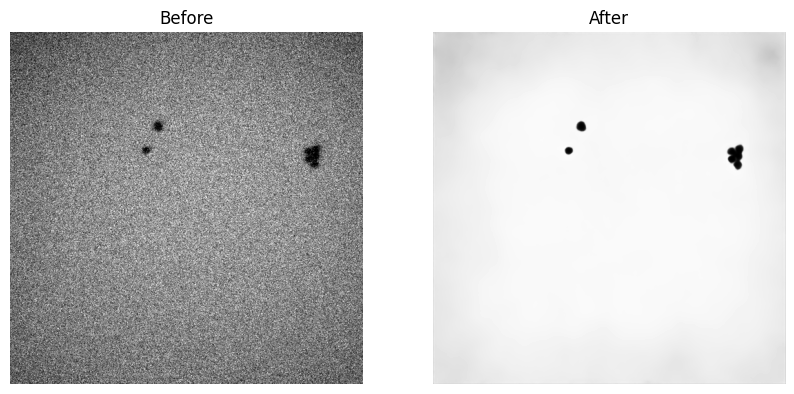

In [6]:
displayfigures(im1,im2)

## Dataset

In [7]:
newname=listdir+listfile

mat = []
with open(newname,'r') as f:
    for line in f.readlines():
        row = []
        toks = line.rstrip('\n').split(' ')
        for tok in toks:
            num = tok
            row.append(num)
        if toks[0]=='':
            continue
        mat.append(row)

In [8]:
def clippedimage(imagedata,imagedir):
    image_truth_train = []
    image_input_train = []
    for i in tqdm(range(len(imagedata))):

        newname1=imagedir+imagedata[i][0]+".tif"
        newname2=imagedir+imagedata[i][5]+".tif"
        x0=np.int32(imagedata[i][1])
        y0=np.int32(imagedata[i][2])
        x1=np.int32(imagedata[i][3])
        y1=np.int32(imagedata[i][4])

        lx=x1-x0
        ly=y1-y0
        
        if os.path.isfile(newname1)!=1:
            print("{} does not exist".format(newname1))
        if os.path.isfile(newname2)!=1:
            print("{} does not exist".format(newname2))
        if os.path.isfile(newname1)!=1 or os.path.isfile(newname2)!=1:
            continue
        img1 = cv2.imread(newname1,-1).astype(np.float32)
        img2 = cv2.imread(newname2,-1).astype(np.float32)

        img1c=np.zeros((figsize,figsize))
        img2c=np.zeros((figsize,figsize))
        a0=int(imagedata[i][6])
        b0=int(imagedata[i][7])
        
        img1c=cv2.resize(img1[y0:y1,x0:x1],(figsize,figsize),interpolation=resize_inter)
        img2c=cv2.resize(img2[b0:b0+ly,a0:a0+lx],(figsize,figsize),interpolation=resize_inter)

        im1=preprocess(img1c)
        im2=preprocess(img2c)
        image_truth_train.append(im1)
        image_input_train.append(im2)

    return image_truth_train, image_input_train


In [9]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    ToTensorV2(),
])

trans2_valid = A.Compose([
    ToTensorV2(),
])

In [10]:
image_truth_train, image_input_train = clippedimage(imagedata=mat,imagedir=imagedir)

100%|█████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.88it/s]


In [11]:
class My_train_dataset(torch.utils.data.Dataset):
    def __init__(self,img_in,img_th):
        self.img_in = img_in
        self.img_th = img_th
        self.transform = transform
        self.n = len(self.img_in)

    def __len__(self):
        return(self.img_in.__len__())
    
    def __getitem__(self,idx):
        p=np.random.rand()
        if p < 0.2:
            transformed = transform(image=self.img_in[idx], mask=self.img_th[idx])
            x = transformed['image']
            y = transformed['mask']
            y = y.unsqueeze(0)
        else:
            im11,im21=self.img_in[idx],self.img_th[idx]

            i2=int(np.random.rand()*self.n)
            im12,im22=self.img_in[i2],self.img_th[i2]

            i3=int(np.random.rand()*self.n)
            im13,im23=self.img_in[i3],self.img_th[i3]

            i4=int(np.random.rand()*self.n)
            im14,im24=self.img_in[i4],self.img_th[i4]

            l=figsize//2
            x=np.zeros([figsize,figsize]).astype('float32')
            x[0:l,0:l]=cv2.resize(im11,(l,l),interpolation=resize_inter)
            x[0:l,l:]=cv2.resize(im12,(l,l),interpolation=resize_inter)
            x[l:,0:l]=cv2.resize(im13,(l,l),interpolation=resize_inter)
            x[l:,l:]=cv2.resize(im14,(l,l),interpolation=resize_inter)

            y=np.zeros([figsize,figsize]).astype('float32')
            y[0:l,0:l]=cv2.resize(im21,(l,l),interpolation=resize_inter)
            y[0:l,l:]=cv2.resize(im22,(l,l),interpolation=resize_inter)
            y[l:,0:l]=cv2.resize(im23,(l,l),interpolation=resize_inter)
            y[l:,l:]=cv2.resize(im24,(l,l),interpolation=resize_inter)

            transformed = transform(image=x, mask=y)
            x = transformed['image']
            y = transformed['mask']
            y = y.unsqueeze(0)
            
        return x, y

train_dataset = My_train_dataset(image_input_train, image_truth_train)

In [12]:
indices = torch.randperm(len(train_dataset)).tolist()
num=train_dataset.__len__()
num=int(0.1*num+1)
train_dataset2 = torch.utils.data.Subset(train_dataset, indices[:-num])
valid_dataset2 = torch.utils.data.Subset(train_dataset, indices[-num:])

In [13]:
train_loader = torch.utils.data.DataLoader(train_dataset2, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True,drop_last=False)
valid_loader = torch.utils.data.DataLoader(valid_dataset2, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [14]:
class CustomLoss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, outputs, targets):
#        L1loss=nn.L1Loss()
#        return (0.8*L1loss(outputs,targets)+0.2*(1.-MySSIM(outputs,targets)))
#        return (3.-MySSIM(outputs,targets,window_size=3)-MySSIM(outputs,targets,window_size=11)-MySSIM(outputs,targets,window_size=39))
        return (1.-MySSIM(outputs,targets))

In [15]:
loss_fn = CustomLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-4)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, min_lr=1e-5)

## Training

In [16]:
res_c_tloss = []
res_c_vloss = []

model = model.to(dev)
    
model.train()

#model.load_state_dict(torch.load("59soltovac-Unet-resnet101_e1000.pth"))

optimizer.zero_grad()

c_vloss_best=100.


for i in range(epoch_init+1, epoch_max+1):
    c_tloss = 0.
    for i2, (inputs, labels) in enumerate(train_loader):
#        print(i2)
#        print(inputs.size())
        inputs, labels = inputs.to(dev), labels.to(dev)
        outputs = model(inputs)
        train_loss = loss_fn(outputs, labels)
        c_loss = train_loss
        c_loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        
        c_tloss += c_loss.item()
        
        
        
    

    if i % 10 == 0:
        model.eval()
        c_vloss=0.
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(dev), labels.to(dev)
                outputs = model(inputs)
                valid_loss = loss_fn(outputs, labels)
                c_loss = valid_loss
                c_vloss += c_loss.item()

        res_c_tloss.append(c_tloss/len(train_loader))
        res_c_vloss.append(c_vloss/len(valid_loader))
        print('Epoch {} {}: {:.4} {:.4} {:.4}'.format(i, datetime.datetime.now(), optimizer.param_groups[0]['lr'], c_tloss/len(train_loader), c_vloss/len(valid_loader)))

        if c_vloss < c_vloss_best:
            c_vloss_best = c_vloss
            newname="{0}_best.pth".format("newparameters")
            torch.save(model.state_dict(), newname)
            
        model.train()

        lr_scheduler.step(c_vloss/len(valid_loader))
        
#    if (i-epoch_init) % ((epoch_max-epoch_init)//10) == 0:
#        newname="{0}_e{1}.pth".format(fnamebase, i)
#        torch.save(model.state_dict(), newname)
        
        




Epoch 10 2023-10-26 15:55:04.377090: 0.0001 0.09541 0.05867
